Enrico Convento -- id:2023572

Load the folling files if you want to avoid re-run the training:



*   vanilla_ab

*   vanilla_ab_scores
*   comp_ab


*   comp_ab_scores



# Acrobot

In [1]:
!pip install gym
!pip install pyvirtualdisplay

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import os
from tqdm.notebook import tqdm


import torch
from torch import nn
from torch import optim

import gym

from collections import deque, OrderedDict

In [3]:
from torchvision import transforms

os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # solving a bug of colab.

## Colab setup

In [4]:
## RENDERING ##

!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

display = Display(visible=0, size=(1400, 900))
display.start()

# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './videos', force=True, video_callable=video_callable)
  return env

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backpor

In [5]:
## Video local saving ##

from gym.wrappers.monitoring import video_recorder

class EnvWrapper():
  '''
  There is bugin the gym code that doesn't allow the proper usage of gym.wrappers.Monitor
  This class allows saving a video of the agent's behavior when using the local machine, by extending some functione of the gym environment.
  
  Agrs:
    env: gym environment
    video_path: string, where to save the video

  '''

  def __init__(self, env, video_path):
    self.env = env
    self.vid = video_recorder.VideoRecorder(self.env,path=video_path)

  def close(self):
    self.vid.close()
    return self.env.close()

  def reset(self):
    return self.env.reset()

  def seed(self, seed):
    return self.env.seed(seed)

  def step(self, *args, **kwargs):
    return self.env.step(*args, **kwargs)

  def render(self, mode='human'):
    r = self.env.render(mode)
    self.vid.capture_frame()
    return r

Check if GPU is available if yes use it if the flag is active

In [6]:
use_gpu = True

# Check if the GPU is available
device = torch.device("cuda") if (torch.cuda.is_available() and use_gpu) else torch.device("cpu")
if use_gpu:
  print(f"Training device: {device}: {torch.cuda.get_device_name(0)}")
else:
  print(f'Training device: {device}')

Training device: cuda: Tesla K80


## Experience replay

In [7]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, next_state, reward):
        self.memory.append((state, action, next_state, reward))

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

## Network

In [8]:
class FCN(nn.Module):
  '''
  Fully connencted network

  Args:
    Ni: input neurons
    Nhs: list of neurons of the hidden layers
    No: output neurons
    activation_function: default nn.ReLU (beware not nn.ReLU() !!)
    o_act: activation function after the output layer, default nn.Identity()
  '''
  def __init__(self, Ni, Nhs=None, No=10, activation_function=nn.ReLU, o_act=nn.Identity()):
    super().__init__()

    self.od = OrderedDict({})
    self.shapes = [Ni]
    if Nhs is not None and len(Nhs) > 0:
      self.shapes += Nhs

    for i,s in enumerate(self.shapes[:-1]):
      self.od.update({f'lin{i+1}': nn.Linear(s, self.shapes[i+1])})
      self.od.update({f'lin_act{i+1}': activation_function()})
    
    self.od.update({'out': nn.Linear(self.shapes[-1], No)})
    self.shapes.append(No)

    self.lin_layers = nn.Sequential(self.od)

    self.o_act = o_act


  def forward(self, x):
    x = self.o_act(self.lin_layers(x))
    return x


## Policies

In [9]:
def random_policy(q_values, temp):
  '''
  Args:
    q_values: array like
    temp: float, ignored

  Returns a random value from 0 to len(q_values) - 1
  '''
  return np.random.randint(q_values.shape[-1])

def greedy_policy(q_values, temp):
  '''
  Args:
    q_values: array like
    temp: float, ignored

  Returns the argmax of q_values
  '''
  return int(q_values.argmax())


def softmax_policy(q_values, temp):
  '''
  Args:
    q_values: array like
    temp: float, temperature of the softmax

  Returns:
    'a' with probability proportional to exp(q_values[a]/temp)
  '''
  if temp < 0:
    raise ValueError(f'temperature must be >= 0, not {temp}')
  if temp == 0:
    return greedy_policy(q_values, temp)

  temp = max(temp, 1e-8) # for numerical stability
  softmax_out = nn.functional.softmax(q_values/temp, dim=0).cpu().numpy()

  return np.random.choice(np.arange(softmax_out.shape[-1]), p=softmax_out)

## Exploration profile

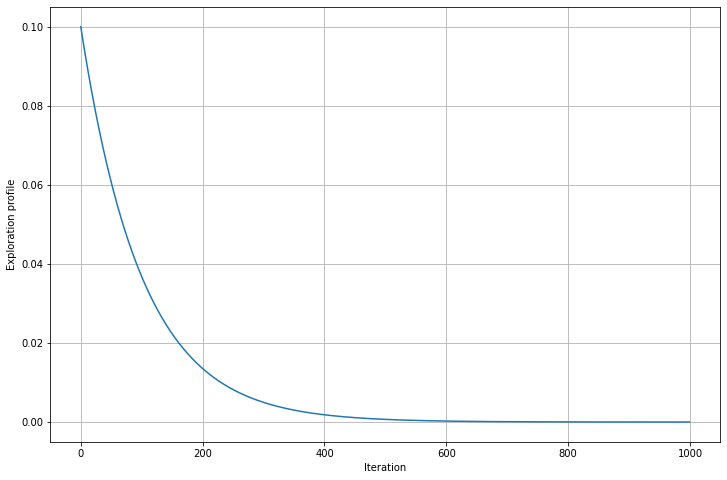

In [10]:
class ExplorationProfile():
  '''
  Temperature decays exponentially from 'start_value' to 'start_value'*exp(-'lam') over 'max_iterations' episodes.
  '''

  def __init__(self, max_iterations=1000, start_value=1, lam=10):
    
    exp_decay = np.exp(-lam/max_iterations)
    self.profile = [start_value * (exp_decay ** i) for i in range(max_iterations)]

  def __len__(self):
    return len(self.profile)

  def __getitem__(self, idx):
    return self.profile[idx]

  def update(self, training):
    '''
    In this base version does nothing
    '''
    return

  def plot(self):
    plt.figure(figsize=(12,8))
    plt.plot(self.profile)
    plt.grid()
    plt.xlabel('Iteration')
    plt.ylabel('Exploration profile')



exploration_profile = ExplorationProfile(start_value=0.1, lam=10)
exploration_profile.plot()

## Agent

In [11]:
class Agent():
  '''
  Class for handling the interaction with a gym environment

  Args:
    env: gym environment
    policy_net: neural network
    policy
  '''

  def __init__(self, env, policy_net, policy=None):
    self.env = env
    self.policy_net = policy_net
    self.policy = policy


    self.score = 0
    self.cumulated_reward = 0
    self.t = 0

    self.reward = 0
    self.state = None

    self.aux_state = None # is the normal state when using pixels
    self.aux_next_state = None

    self.action = None
    self.next_state = None
    self.q_values = None

    self.is_ready = False

  def run_episode(self, temp=0, max_score=500, min_score=-np.infty, modifier=None, verbose=True, test=False):
    '''
    Runs a single episode on the environment.

    Args:
      temperature: float (default 0): parameter for the policy
      max_score: (default 500)
      min_score: (default -np.infty):
        stop interaction with the environment when score >= max_score or score <= min_score
      modifier: None or function
        modifies the reward and the score of the agent and takes care of optimizing the policy net parameters and to push samples to the replay memory
      verbose: bool (default True)
    '''
    if test:
      states = []
      qvalues = []

    self.t = 0
    self.score = 0
    self.cumulated_reward = 0
    self.q_values = torch.zeros(self.policy_net.shapes[-1], dtype=torch.float32)
    self.action = random_policy(self.q_values, 0) # select first action randomly in case the agent cannot evaluate the policy net
    done = False


    self.state = self.aux_state = self.env.reset()

    while not done and self.score < max_score and self.score > min_score:
      try:
        
        # compute q values
        self.policy_net.eval()
        with torch.no_grad():
          
          self.q_values = self.policy_net(torch.tensor(self.state, dtype=torch.float32))
          if test:
            states.append(self.state)
            qvalues.append(self.q_values)
        # choose action
        self.action = self.policy(self.q_values, temp)
        self.is_ready = True
      except KeyboardInterrupt:
        raise KeyboardInterrupt
      except:
        self.is_ready = False
        self.action = random_policy(self.q_values, 0) # select first action randomly in case the agent cannot evaluate the policy net


      # apply action
      self.next_state, self.reward, done, info = self.env.step(self.action)

      self.aux_next_state = self.next_state


      if done:
        self.next_state = None

      # call the modifier
      if modifier == None:
        agent.score += 1
      else:
        modifier(self)

      # update cumulated reward
      self.cumulated_reward += self.reward

      
      self.state = self.next_state
      self.aux_state = self.aux_next_state

      self.t += 1

    if verbose:
      print(f' score: {self.score}')
    if test:
      return states,qvalues


## Training

In [12]:
class Training():
  '''
  Class for training an agent.

  Args:
    agent: Agent
    target_net: net to be used for computing expected Q-values.
    update_target_net_every: number of episodes every which to update the target net

    optimizer_type
    optimizer_params
    loss_function

    memory_capacity
      maximum number of samples for the replay memory
    min_samples
      minimum number of samples in the replay memory to start training the agent
    batch_size

    discount_rate

    gradient_clip_value
      Clips the norm of the gradient of the weight of the training net

    score_to_beat:
      minimum score by the agent at the end of an episode for considering the game beaten


    device: GPU or CPU: default None, i.e. CPU
  '''

  def __init__(self, agent, target_net, optimizer_type, optimizer_params, loss_function, 
               memory_capacity=10000, min_samples=1000, batch_size=256,
               discount_rate=0.97, gradient_clip_value=2,
               score_to_beat=500, update_target_net_every=10, device=None):
    
    self.agent = agent
    self.target_net = target_net
    self.target_net.load_state_dict(self.agent.policy_net.state_dict())

    self.optimizer = optimizer_type(self.agent.policy_net.parameters(), **optimizer_params)

    self.loss_function = loss_function

    self.replay_mem = ReplayMemory(memory_capacity)
    self.min_samples = min_samples
    self.batch_size = batch_size

    self.discount_rate = discount_rate
    self.gradient_clip_value = gradient_clip_value

    self.device = device

    self.episode_num = 0
    self.perfect_consecutive_episodes = 0

    self.score_to_beat = score_to_beat
    self.update_target_net_every = update_target_net_every

    self.score_log = []
    self.cumulated_reward_log = []

  def __len__(self):
    return len(self.score_log)

  def give_reward(self, agent):
    # simply modify the score, no penalties or bonuses to the reward
    agent.score += 1


  def modifier(self, agent):
    '''
    Function that is passed to agent.run_episode
    '''
    # modify the reward of the agent: e.g. add penalties
    self.give_reward(agent)

    # add new samples to the replay memory
    self.replay_mem.push(agent.state, agent.action, agent.next_state, agent.reward)
    if len(self.replay_mem) == self.min_samples:
      print('\n\nInitiating learning\n\n')
    if len(self.replay_mem) > self.min_samples:
      # update policy net
      self.update_step()


  def update_target_net(self, verbose=False):
    if self.episode_num % self.update_target_net_every == 0:
      if verbose:
        print('Updating target net')
      self.target_net.load_state_dict(self.agent.policy_net.state_dict())


  def train(self, profile, verbose=False, min_perfect_episodes=10, max_score=500, min_score=-np.infty):
    '''
    Train the agent:

    Args:
      profile: ExplorationProfile instance. Learning will last at most len(profile) episodes
      verbose
      min_perfect_episodes
        when the agent beats the game for min_perfect_episodes consecutive episodes learning stops.


      Parameters that are simply passed to agent.run_episode:
      
        max_score
        min_score
    '''
    if self.device is not None:
      self.agent.policy_net.to(self.device)
      self.target_net.to(device)

    while self.episode_num < len(profile):
      temp = profile[self.episode_num]
      if verbose:
        print(f'Episode {self.episode_num}: temp = {temp :.3e} -->',end='')

      # run an episode
      self.agent.run_episode(temp=temp, max_score=max_score, min_score=min_score, modifier= self.modifier, verbose=verbose)
      # update target net
      self.update_target_net(verbose=verbose)

      # check if the agent beated the game
      if self.agent.score >= self.score_to_beat:
        self.perfect_consecutive_episodes += 1
      else:
        self.perfect_consecutive_episodes = 0

      self.episode_num += 1
      self.score_log.append(self.agent.score)
      self.cumulated_reward_log.append(self.agent.cumulated_reward)

      # update the temp profile
      profile.update(self)

      # stop updating if the agent consistently beats the game
      if self.perfect_consecutive_episodes == min_perfect_episodes:
        if verbose:
          print('\n\n Game consistently beaten')
        break

  
  def update_step(self):
    '''
    Updates the policy net of the agent
    '''

    # Sample the data from the replay memory
    batch = self.replay_mem.sample(self.batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    
    states                = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended

    actions                 = torch.tensor([s[1] for s in batch], dtype=torch.int64, device=self.device)
    rewards                 = torch.tensor([s[3] for s in batch], dtype=torch.float32, device=self.device)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool, device=self.device)

    # Compute all the Q values (forward pass)
    self.agent.policy_net.train()
    q_values = self.agent.policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      self.target_net.eval()
      q_values_target = self.target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size, device=self.device)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * self.discount_rate)
    # Set the required tensor shape
    expected_state_action_values = expected_state_action_values.unsqueeze(1)

    # Compute the Huber loss
    loss = self.loss_function(state_action_values, expected_state_action_values)

    # Optimize the model
    self.optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (for training stability)
    if self.gradient_clip_value > 0:
      nn.utils.clip_grad_norm_(self.agent.policy_net.parameters(), self.gradient_clip_value)
    self.optimizer.step()

    del loss
    del q_values
    del state_action_values
    torch.cuda.empty_cache()

The height of the end point of the pendulum can computed as follow
$h = −(cos(θ_1) + cos(θ_1 + θ_2) = sin θ_1 sin θ_2 − cos θ_1(1 + cos θ_2)$

In [13]:
def height(t1, t2):
  return np.sin(t1)*np.sin(t2) - np.cos(t1)*(1 + np.cos(t2))

## TEST ##
print ('height =', height(np.pi/4,np.pi/4))

height = -0.7071067811865476


In [14]:
class Training_acrobot(Training):
  '''
  Modifies the reward adding to it 

  'w_h'*height**'e_h' 
  '''

  def __init__(self, *args, height_weight=0, height_exponent=1, end_state_penalty=0, **kwargs):
    super().__init__(*args, **kwargs)

    self.h_w = height_weight
    self.h_exp = height_exponent
    self.end_state_penalty = end_state_penalty

  def give_reward(self, agent):
    agent.score -= 1

    if agent.next_state is None:
      agent.reward += self.end_state_penalty

    else:
      a_s = agent.aux_next_state
      height = a_s[1]*a_s[3] - a_s[0]*(1 + a_s[2]) + 2
       # this way it is 0 when the pendulum is resting downwards
      agent.reward += self.h_w*height**self.h_exp 

## Setup

In [15]:
### Create environment
env = gym.make('Acrobot-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

env.close()


STATE SPACE SIZE: 6
ACTION SPACE SIZE: 3


In [16]:
## TEST ##
env.reset()
policy_net = FCN(Ni=state_space_dim,No=action_space_dim,)
agent = Agent(env,policy_net,policy=random_policy)
agent.run_episode()
env.close()

 score: 500


### Vanilla version

In [17]:
net_params = {'Ni': state_space_dim, 'Nhs': [128, 128], 'No': action_space_dim, 'activation_function': nn.Tanh}

policy_net = FCN(**net_params)
target_net = FCN(**net_params)

agent = Agent(None,policy_net,policy=softmax_policy) # for now set the env to None

params = {'agent': agent, 'target_net': target_net, 'optimizer_type': optim.SGD, 'optimizer_params': {'lr': 1e-2},
                  'loss_function': nn.SmoothL1Loss(), 'batch_size': 128,
                  'end_state_penalty': 10,
                  'update_target_net_every': 10, 'score_to_beat': -100}

trainer = Training_acrobot(**params)
trainer.score_to_beat = - 100



Episode 0: temp = 1.000e-01 --> score: -400
Updating target net
Episode 1: temp = 9.900e-02 --> score: -400
Episode 2: temp = 9.802e-02 -->

Initiating learning




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


 score: -400
Episode 3: temp = 9.704e-02 --> score: -400
Episode 4: temp = 9.608e-02 --> score: -400
Episode 5: temp = 9.512e-02 -->

Training interrupted




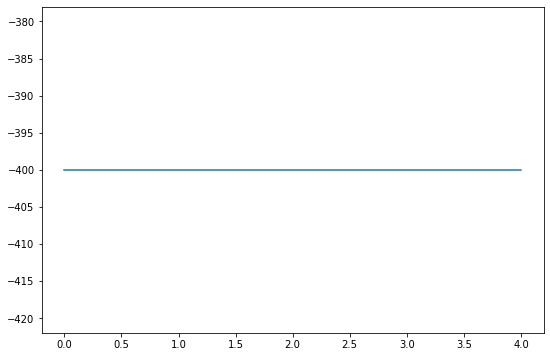

In [ ]:
# Run this cell only if you want to perform the training

agent.env = gym.make('Acrobot-v1')
agent.env.seed(0)

try:
  trainer.train(exploration_profile,verbose=True, min_score=-400)
except KeyboardInterrupt:
  print('\n\nTraining interrupted\n\n')
agent.env.close()

plt.figure(figsize=(9,6))
plt.plot(trainer.score_log)

Text(0, 0.5, 'T profile')

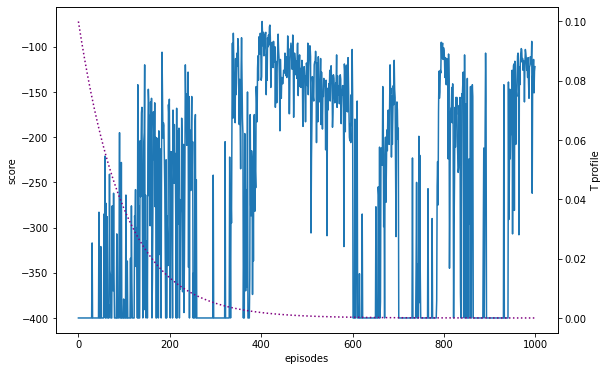

In [18]:
## Saving model ##
#torch.save(trainer.agent.policy_net.state_dict(), 'vanilla_ab')

trainer.agent.policy_net.load_state_dict(torch.load('vanilla_ab'))

import pickle
## SAVE SCORES AND PARAMS ##

#with open("vanilla_ab_scores", "wb") as fp:   #Pickling
#  pickle.dump(trainer.score_log, fp)


## LOAD SCORES AND PARAMS ##
with open("vanilla_ab_scores", "rb") as fp:   # Unpickling
  episodes_trajectories = pickle.load(fp)
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(episodes_trajectories)

ax.set_ylabel('score' )
ax.set_xlabel('episodes')

ax2 = ax.twinx()
ax2.plot(exploration_profile.profile[:len(episodes_trajectories)], color='purple', linestyle='dotted')
ax2.set_ylabel('T profile')


### Improved version

In [19]:
net_params = {'Ni': state_space_dim, 'Nhs': [128, 128], 'No': action_space_dim, 'activation_function': nn.Tanh}

policy_net = FCN(**net_params)
target_net = FCN(**net_params)

agent = Agent(None,policy_net,policy=softmax_policy) # for now set the env to None

params = {'agent': agent, 'target_net': target_net, 'optimizer_type': optim.SGD, 'optimizer_params': {'lr': 1e-2},
                  'loss_function': nn.SmoothL1Loss(), 'batch_size': 128,
                  'height_weight': 0.5, 'height_exponent': 1, 'end_state_penalty': 10,
                  'update_target_net_every': 10, 'score_to_beat': -100}

trainer = Training_acrobot(**params)
trainer.score_to_beat = - 100



Episode 0: temp = 1.000e-01 --> score: -400
Updating target net
Episode 1: temp = 9.900e-02 --> score: -400
Episode 2: temp = 9.802e-02 -->

Initiating learning


 score: -400
Episode 3: temp = 9.704e-02 -->

Training interrupted




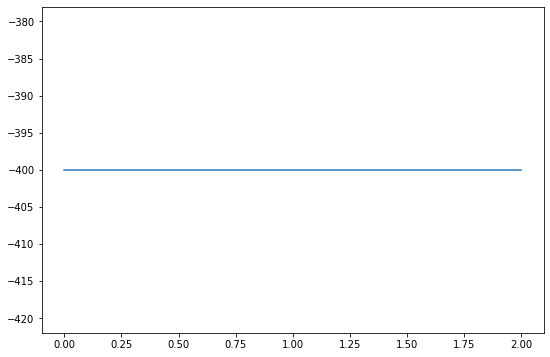

In [ ]:
# Run this cell only if you want to perform the training


agent.env = gym.make('Acrobot-v1')
agent.env.seed(0)

try:
  trainer.train(exploration_profile,verbose=True, min_score=-400)
except KeyboardInterrupt:
  print('\n\nTraining interrupted\n\n')
agent.env.close()

plt.figure(figsize=(9,6))
plt.plot(trainer.score_log)

Text(0, 0.5, 'T profile')

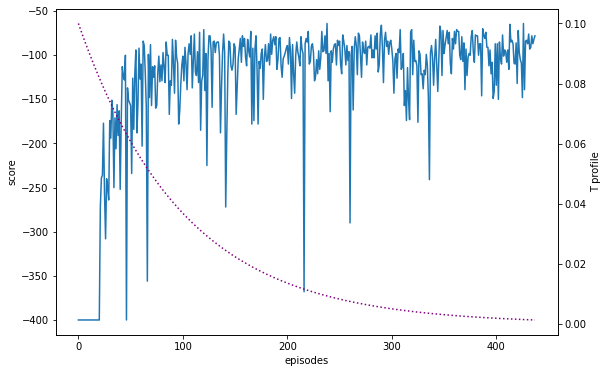

In [20]:
## Saving model ##
#torch.save(trainer.agent.policy_net.state_dict(), 'comp_ab')

trainer.agent.policy_net.load_state_dict(torch.load('comp_ab'))

import pickle
## SAVE SCORES AND PARAMS ##

#with open("comp_ab_scores", "wb") as fp:   #Pickling
#  pickle.dump(trainer.score_log, fp)


## LOAD SCORES AND PARAMS ##
with open("comp_ab_scores", "rb") as fp:   # Unpickling
  episodes_trajectories = pickle.load(fp)

fig, ax = plt.subplots(figsize=(9,6))
ax.plot(episodes_trajectories)

ax.set_ylabel('score' )
ax.set_xlabel('episodes')

ax2 = ax.twinx()
ax2.plot(exploration_profile.profile[:len(episodes_trajectories)], color='purple', linestyle='dotted')
ax2.set_ylabel('T profile')

### Final test

In [21]:
def mod(agent):
  agent.score -= 1

In [22]:
agent.env = gym.make('Acrobot-v1')
agent.env.seed(0)


scores = []
motorized_actions_percs = []
for i in range(100):
  states, qvalues = trainer.agent.run_episode(temp=0., modifier=mod, test = True)
  actions = [int(q.argmax()) for q in qvalues]
  a = np.array(actions) - 1
  scores.append(trainer.agent.score)
agent.env.close()

print('\n\n\n############################### \n      MEAN SCORE:  ', np.mean(scores),'\n###############################')

 score: -131
 score: -186
 score: -76
 score: -84
 score: -98
 score: -85
 score: -112
 score: -101
 score: -75
 score: -74
 score: -63
 score: -73
 score: -63
 score: -96
 score: -184
 score: -81
 score: -78
 score: -76
 score: -77
 score: -108
 score: -85
 score: -75
 score: -73
 score: -77
 score: -76
 score: -91
 score: -93
 score: -72
 score: -75
 score: -89
 score: -82
 score: -131
 score: -88
 score: -78
 score: -78
 score: -93
 score: -80
 score: -71
 score: -77
 score: -86
 score: -106
 score: -79
 score: -79
 score: -98
 score: -94
 score: -82
 score: -78
 score: -78
 score: -78
 score: -65
 score: -85
 score: -114
 score: -97
 score: -77
 score: -63
 score: -73
 score: -134
 score: -87
 score: -82
 score: -78
 score: -79
 score: -105
 score: -74
 score: -89
 score: -72
 score: -91
 score: -94
 score: -88
 score: -72
 score: -85
 score: -86
 score: -79
 score: -77
 score: -77
 score: -83
 score: -72
 score: -63
 score: -85
 score: -71
 score: -86
 score: -92
 score: -95
 scor